# Homework 3 CSCI 4364/6364 Machine Learning

## **A Tour of Multivariate Classification**

**Due Date: 10/17/2023, 23:59 ET**

---

**Purpose:**
This homework will provide you with hands-on experience with some of the multivariate classification algorithms we discussed in class and expose you to one of the most cited datasets, MNIST.

You should get a broad appreciation for the various approaches to classification that will help you evaluate which approach is best for your real world research or industry application.

The [MNIST](http://yann.lecun.com/exdb/mnist/) database of handwritten digits has a training set of 60,000 examples, and a test set of 10,000 examples. It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. MNIST is a good dataset for this assignment, since it has 10 classes (0 - 9) with a large number of features.


---
**Submission Instructions:**
This assignment will be done entirely in this Colaboratory notebook, and you will submit your notebook via GWU blackboard. Please embed your code in code blocks and add in comments into the text blocks.

> **Important:** Please save and submit your homework assignment notebook with outputs. You can do this by selecting `Edit` >> `Notebook settings` and making sure the option `Omit code cell output when saving this notebook` is **NOT** selected.

**Grading on the notebook:**
This notebook is worth up to 5% (with up to 3% additional extra credit) of the semester grade, where 3% is completion and full functionality, and 2% is based on comments and descriptions, and well-written and commented Python code, based on the coding standards. The notebook should be fully explained and work in its entirety when you submit it.

**Coding Standards:**
Throughout this course, we will use [Google’s Python Style Guide](https://google.github.io/styleguide/pyguide.html) as the coding standard for homework and project submission. A big part of machine learning in industry is applying good programming practices.


**Name:** Eljan Mahammadli

**GW ID:** G28982750

In [ ]:
#@title Imports
##########################################################
# Always include all imports at the first executable cell.
##########################################################
from sklearn.datasets import fetch_openml
from keras.utils import to_categorical
import numpy as np
import time
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod # Abstract Base Classes for Python
import matplotlib.image as mpimg
import seaborn as sns; sns.set()
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from typing import Dict, Optional
import tensorflow as tf
from gc import callbacks

First, download the MNIST data using the code provided below.

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


Here are the first 9 digits of the MNIST data with label.


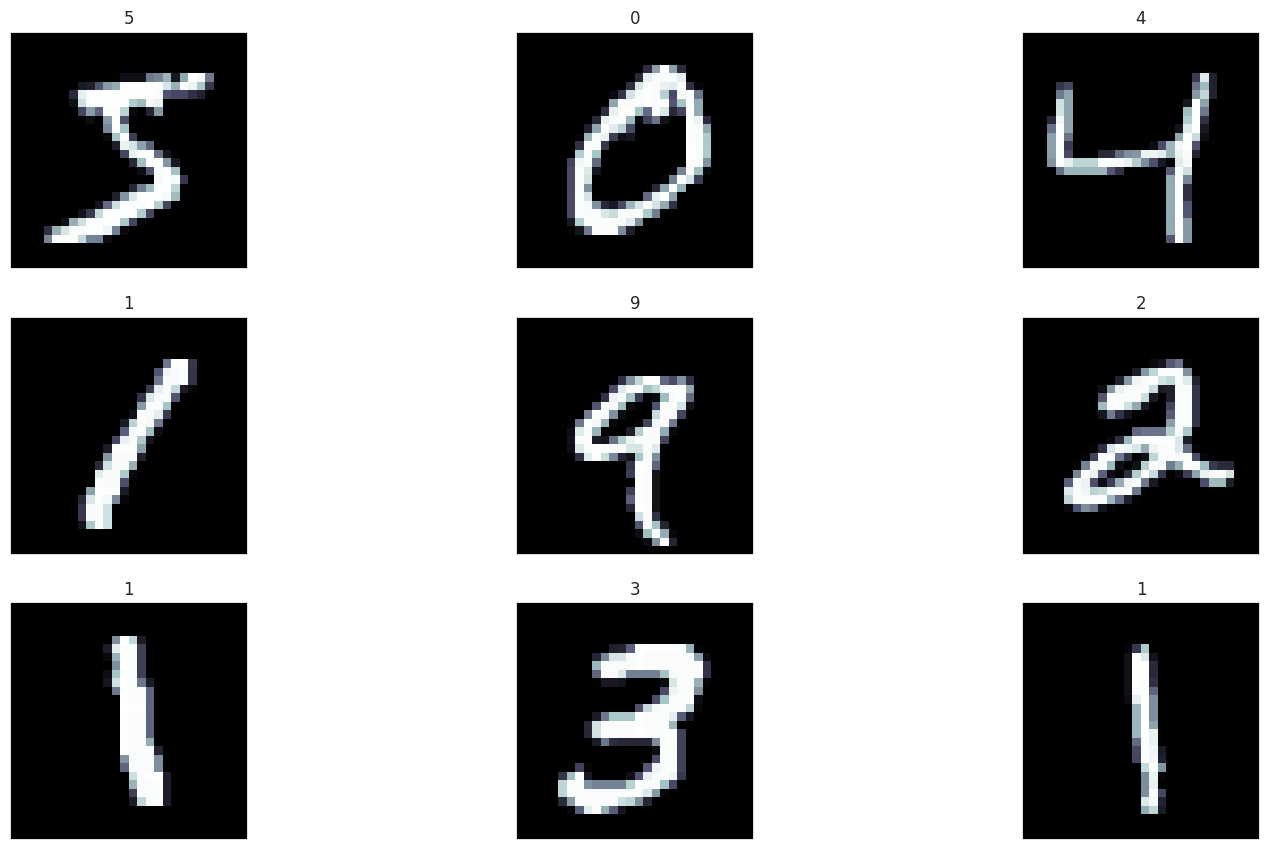

In [ ]:
#@title Download MNIST, split, and plot example
def plot_example(x_raw, y_raw):
  fig, axes = plt.subplots(3, 3)
  i = 0
  for i in range(3):
    for j in range(3):
      imgplot = axes[i,j].imshow(x_raw[i*3 + j].reshape((28,28)), cmap = 'bone')
      axes[i,j].set_title(y_raw[i*3 + j])
      axes[i,j].get_yaxis().set_visible(False)
      axes[i,j].get_xaxis().set_visible(False)
  fig.set_size_inches(18.5, 10.5, forward=True)


x_raw, y_raw = fetch_openml('mnist_784', version=1, return_X_y=True)
x = (x_raw/255).astype('float32').to_numpy()

# Split the data set into train, validation, and test sets.
x_trainval, x_test, y_trainval, y_test = train_test_split(x, y_raw, test_size=0.10, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_trainval, y_trainval, test_size=0.10, random_state=42)
print('Here are the first 9 digits of the MNIST data with label.')
plot_example(x, y_raw)

As in the past assignments, we'll define our base learning algorithm class, and create multiple implementations. Here, in the fit (or train) method, along with x_train and y_train, we'll include x_val, and y_val, as validation sets. Not all implementations will use them.

In [ ]:
#@title Define a base class class for Learning Algorithm

class BaseLearningAlgorithm(ABC):
  """Base class for a Supervised Learning Algorithm."""

  @abstractmethod
  def fit(self, x_train:np.array, y_train: np.array
          , x_val:np.array
          , y_val:np.array) -> None:
    """Trains a model from labels y and examples X.
    We include validation set for optional hyperparameter tuning. Not
    all of the algorithims we use will
    """

  @abstractmethod
  def predict(self, x_test: np.array) -> np.array:
    """Predicts on an unlabeled sample, X."""

  @property
  @abstractmethod
  def name(self) -> str:
    """Returns the name of the algorithm."""

Next, we want to establish a common approach to evaluating our implementations of `BaseLearningAlgorithm`.

A **Confusion Matrix** is a data table that helps visualize the performance of a multi-class classifier. The rows represent the true class assignmants from the test set labels, and the columns represent the predicted classes generated by the classifier. A perfect classifier will only populate the diagonal with counts and all off-diagonal elements of the matrix will be zero. Off-diagonal counts indiate that the model confuses the class in row $i$ with the class in column $j$. For example, in MNIST, the number $9$ might be confused $4$, and the associated cell at $i, j$ will be greater than $0$.

Besides precision and accuracy, the **F1-Score** is often used.  Review this [Wikipedia article](https://en.wikipedia.org/wiki/F-score) on F-Score.

##Question 1.
The Wikipedia article indicates that one weakness of the F-Score is that it assigns equal importance to precision and recall. Describe two scenarios where (a) precision may be more important to recall, and (b) where recall may be more important than precision. So we would value recall (also know as "True Positive Rate") over precision.

- Let's first define the formulas of both precision and recall:

$$\text{Precision} = \frac{\text{True Positives (TP)}}{\text{True Positives (TP) + False Positives (FP)}}$$

$$\text{Recall} = \frac{\text{True Positives (TP)}}{\text{True Positives (TP) + False Negatives (FN)}}$$

<br>

- The first scenario that comes to my mind is the classic cancer detection (or any kind of medical case test of serious illness). In this case we would not want to miss any patient who is cancer which may have very bad consequences.

- For the second scenario I can speak from my experience in credit scoring in banking industry where the precision is more valuable (each institute may have different strategy indeed). If the model classifies a bad customer as a good (false positive) then this may result in the default of the customer.

In [ ]:
#@title Define a basic train and evaluation pipeline

def train_eval(learning_algo: BaseLearningAlgorithm, x_train, y_train,x_val, y_val, x_test, y_test):
  """Trains and evaluates the generic model."""
  y_test = y_test.astype('float32')
  learning_algo.fit(x_train, y_train, x_val, y_val)
  y_pred = learning_algo.predict(x_test)
  mat = confusion_matrix(y_test, y_pred)
  sns.set(rc = {'figure.figsize':(8,8)})
  sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
              xticklabels=['%d' %i for i in range(10)],
              yticklabels=['%d' %i for i in range(10)])
  plt.xlabel('true label')
  plt.ylabel('predicted label')
  plt.title(learning_algo.name)

  print(classification_report(y_test, y_pred,
                              target_names=['%d' %i for i in range(10)]))

#1. Linear model with Logistic Regression
Let's start with basic logistic regression and demonstrate that Logistic Regression works on a multiclass classification problem.

We'll use the familiar least squares regression model with L2 regularization as a baseline for comparison.

In [ ]:
# each example (e.g image) has 784 features which is the flattened pixels of 2d
(x_train.shape, y_train.shape)

((56700, 784), (56700,))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       683
           1       0.94      0.97      0.96       800
           2       0.90      0.89      0.90       674
           3       0.89      0.89      0.89       760
           4       0.92      0.93      0.92       611
           5       0.89      0.88      0.89       658
           6       0.94      0.95      0.94       677
           7       0.93      0.94      0.93       724
           8       0.90      0.86      0.88       693
           9       0.92      0.90      0.91       720

    accuracy                           0.92      7000
   macro avg       0.92      0.92      0.92      7000
weighted avg       0.92      0.92      0.92      7000

CPU times: user 8min 28s, sys: 30.5 s, total: 8min 59s
Wall time: 5min 15s


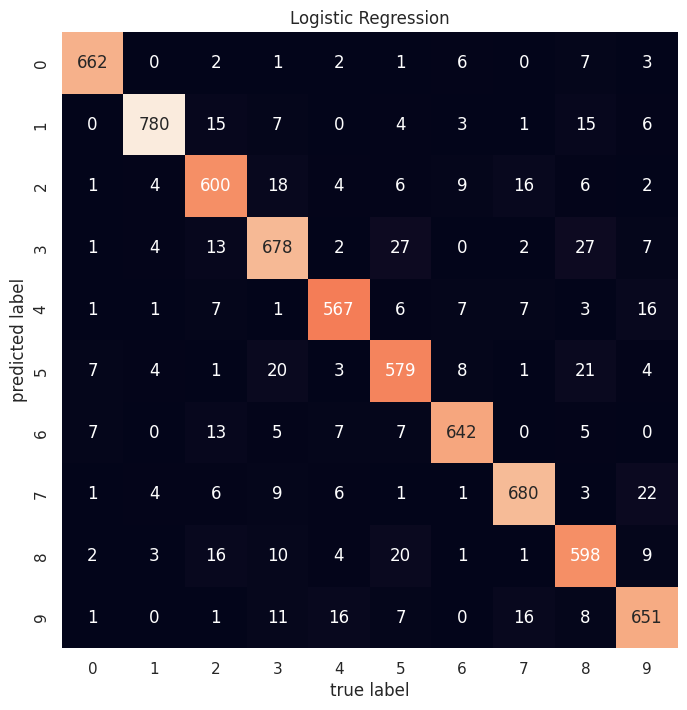

In [ ]:
#@title Define the basic Logistic Regression Model

class LogisticRegressionLearningAlgorithm(BaseLearningAlgorithm):
  """Minimalist wrapper class for basic Logistic Regression."""

  def __init__(self, max_iters: int = 1000):
    self._model = LogisticRegression(max_iter = max_iters, verbose = True, penalty = 'l2')

  def fit(self, x_train:np.array, y_train: np.array, x_val:np.array, y_val: np.array) -> None:
    self._model.fit(x_train,y_train)
    # Don't need the validation data in Logistic Regression

  def predict(self, x_test: np.array) -> np.array:
    return self._model.predict(x_test)

  @property
  def name(self) -> str:
    return 'Logistic Regression'

learning_algo = LogisticRegressionLearningAlgorithm(max_iters = 1000)
%time train_eval(learning_algo, x_train, y_train, x_val, y_val, x_test, y_test)

#2. Support Vector Machine + Principal Components Analysis
In this section, we'll investigate the Support Vector Machine with and without dimensionality reduction using PCA.

##2.1 Basic SVM (Task 1)
In the block below, use Scikit-Learn's SVM classifier, SVC. Configure the SVC with a Radial Basis Function Kernel (RBF), and parameterize the cost value and the RBF gamma parameter.

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       683
           1       0.94      0.98      0.96       800
           2       0.92      0.92      0.92       674
           3       0.91      0.90      0.90       760
           4       0.89      0.94      0.92       611
           5       0.90      0.90      0.90       658
           6       0.95      0.96      0.96       677
           7       0.95      0.94      0.95       724
           8       0.94      0.88      0.91       693
           9       0.93      0.91      0.92       720

    accuracy                           0.93      7000
   macro avg       0.93      0.93      0.93      7000
weighted avg       0.93      0.93      0.93      7000

CPU times: user 10min 4s, sys: 656 ms, total: 10min 5s
Wall time: 10min 10s


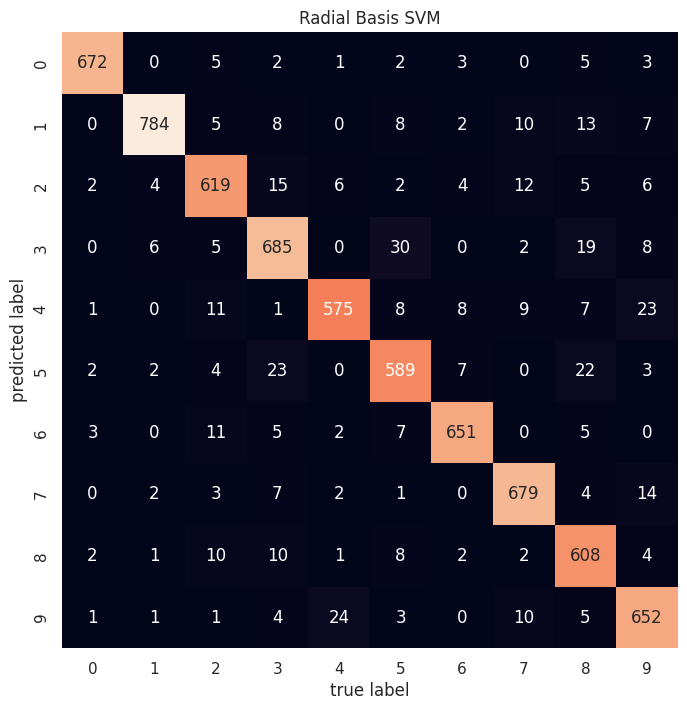

In [ ]:
#@title Define SVM Model with Radial Basis kernel

class RadialBasisSvmLearningAlgorithm(BaseLearningAlgorithm):
  """RBF SVM Classifier function."""

  def __init__(self, cost: float, gamma: float):
    self.cost = cost
    self.gamma = gamma
    self._model = SVC(C=cost, gamma=gamma, kernel='rbf')

  def fit(self, x_train:np.array, y_train: np.array, x_val:np.array, y_val: np.array) -> None:
    self._model.fit(x_train, y_train)

  def predict(self, x_test: np.array) -> np.array:
    return self._model.predict(x_test)

  @property
  def name(self) -> str:
    return 'Radial Basis SVM'

learning_algo = RadialBasisSvmLearningAlgorithm(cost = 10.0, gamma = 0.0001)
%time train_eval(learning_algo, x_train, y_train, x_val, y_val, x_test, y_test)

##2.2 Dimensionality Reduction with PCA (Task 2)

Next, we'll use PCA to reduce the input space from 784 dimensions to lower dimensions with lower variance. But how how many dimensions do we choose to keep? To help deceide that, we should first plot out the explained varaince by the number of singular values. This gives us picture of how much information is lost by removing the smallest singular values.  

In the code below, use Scikit-Learn's PCA class with `x_train` and plot out the explained variance ratio against the number of components (singular values).  

(784,) 0.9999999


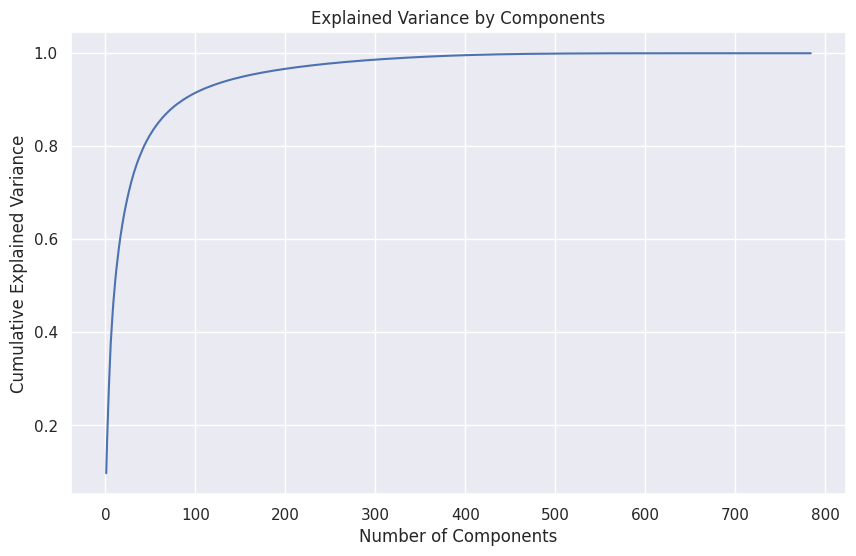

In [ ]:
#@title Fit PCA and plot the explained variance as a function of components

# fitting pca to the train data
pca = PCA()
pca.fit(x_train)
print(pca.explained_variance_ratio_.shape, np.sum(pca.explained_variance_ratio_))

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_.cumsum(), linestyle='-')
plt.title('Explained Variance by Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

##Question 2.
Based on the variance vs. num components chart above, how many components represent 80% and 90% of the explained variance?

- Using the code below, we see that 42 and 86 components is represent the 80% and 90% of the explained variance respectively.

In [ ]:
#@title Find the number of components that represent 80% and 90% of the explained variance

cumulative_variance = pca.explained_variance_ratio_.cumsum()

components_80 = len(cumulative_variance[cumulative_variance <= 0.80])
components_90 = len(cumulative_variance[cumulative_variance <= 0.90])

print(f"Number of components for 80% explained variance: {components_80}")
print(f"Number of components for 90% explained variance: {components_90}")

Number of components for 80% explained variance: 42
Number of components for 90% explained variance: 86


##2.2 Apply PCA to reduce dimensionality for SVM (Task 3)

In the code block below, extend the basic SVM class from 2.1 and name it `RadialBasisSvmPcaLearningAlgorithm` that first reduces the dimension. You can use Scikit-Learn's `make_pipeline()` method to combine PCA and SVC into a pipeline.

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       683
           1       0.93      0.98      0.95       800
           2       0.90      0.92      0.91       674
           3       0.91      0.89      0.90       760
           4       0.89      0.94      0.91       611
           5       0.90      0.89      0.89       658
           6       0.95      0.96      0.95       677
           7       0.95      0.93      0.94       724
           8       0.93      0.87      0.90       693
           9       0.93      0.89      0.91       720

    accuracy                           0.93      7000
   macro avg       0.93      0.93      0.93      7000
weighted avg       0.93      0.93      0.93      7000

CPU times: user 2min 15s, sys: 2.39 s, total: 2min 17s
Wall time: 2min 21s


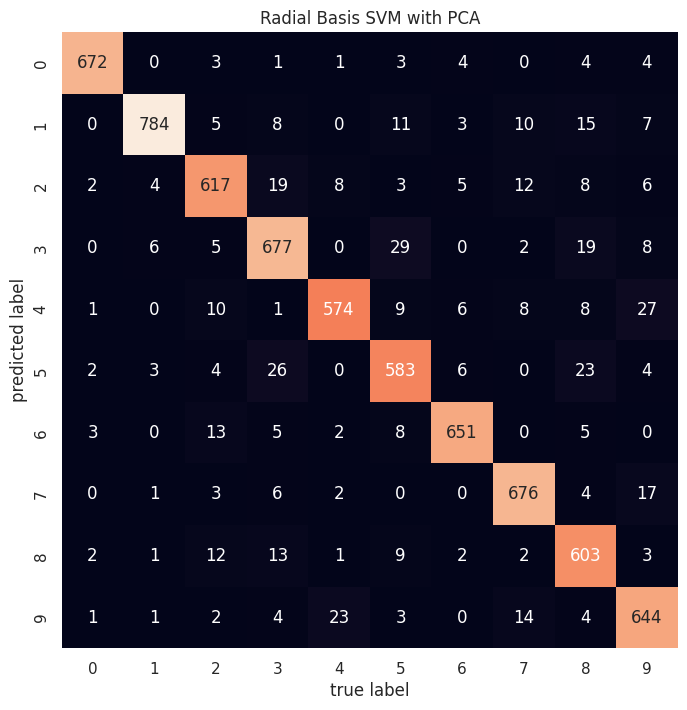

In [ ]:
#@title Define the Radial Basis SVM Model with PCA applied

class RadialBasisSvmPcaLearningAlgorithm(RadialBasisSvmLearningAlgorithm):
  """RBM SVM Classifier with PCA applied class"""
  def __init__(self, cost: float, gamma: float, num_pca_components: int):
    super().__init__(cost, gamma)
    self.num_pca_components = num_pca_components
    self._model = make_pipeline(
        PCA(n_components=self.num_pca_components),
        SVC(C=self.cost, gamma=self.gamma, kernel='rbf')
    )

  def fit(self, x_train:np.array, y_train: np.array, x_val:np.array, y_val: np.array) -> None:
    self._model.fit(x_train, y_train)

  def predict(self, x_test: np.array) -> np.array:
    return self._model.predict(x_test)

  @property
  def name(self) -> str:
    return "Radial Basis SVM with PCA"

learning_algo = RadialBasisSvmPcaLearningAlgorithm(num_pca_components=71, cost = 10.0, gamma = 0.0001)
%time train_eval(learning_algo, x_train, y_train, x_val, y_val, x_test, y_test)


##Question 3.
What is the minimum number of components required to achieve equivalent performance to basic SVM without PCA (2.1)?

- After testing some numbers between 42 and 86, I was able reproduce the result of the SVM without applying PCA when the number of the components is 71 (nearly when we preserve the 90%) of the explained variance. We could of course use a `for` loop to assert this number effectively but in this case I did not need as it was straightforward to find this number.

#3. Random Forest

In this section, we'll investigate the Random Forest algorithm that aggregates its answer using many decorrelated trees.

##3.1 Tuning the Random Forest (Task 4)
In the code black below, write an extension class to `BaseLearningAlgorithm` called `RandomForestLearningAlgorithm` using Scikit-Learn's RandomForestClassifier. You should parameterize the class with the number of estimators (i.e., number of trees), type of split (gini or entropy), max tree depth, minimum number of samples per node.

Without doing a formal hyperparameter tuning, like grid search, try a few variations to improve overall accuracy.

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       683
           1       0.98      0.98      0.98       800
           2       0.94      0.97      0.95       674
           3       0.95      0.95      0.95       760
           4       0.96      0.96      0.96       611
           5       0.98      0.95      0.97       658
           6       0.98      0.98      0.98       677
           7       0.97      0.96      0.96       724
           8       0.95      0.95      0.95       693
           9       0.96      0.94      0.95       720

    accuracy                           0.96      7000
   macro avg       0.96      0.96      0.96      7000
weighted avg       0.96      0.96      0.96      7000

CPU times: user 3min 51s, sys: 205 ms, total: 3min 51s
Wall time: 3min 51s


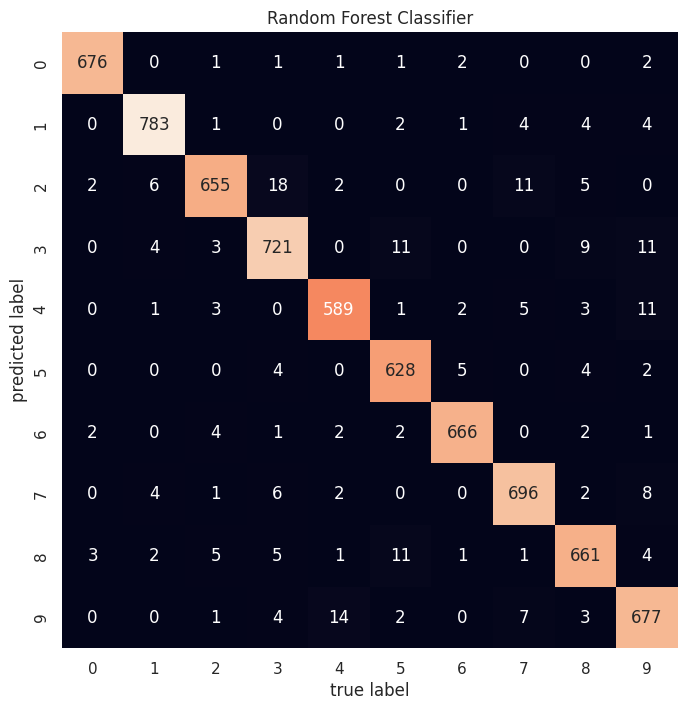

In [ ]:
#@title Define the Random Forest Classifier

class RandomForestLearningAlgorithm(BaseLearningAlgorithm):
  """Random Forest Classifier class"""
  def __init__(self, n_estimators: int, criterion: str, max_depth: int, min_samples_split: int):
    self.n_estimators = n_estimators
    self.criterion = criterion
    self.max_depth = max_depth
    self.min_samples_split = min_samples_split
    self._model = RandomForestClassifier(n_estimators=self.n_estimators, criterion=self.criterion, max_depth=self.max_depth, min_samples_split=self.min_samples_split)

  def fit(self, x_train:np.array, y_train: np.array, x_val:np.array, y_val: np.array) -> None:
    self._model.fit(x_train, y_train)

  def predict(self, x_test: np.array) -> np.array:
    return self._model.predict(x_test)

  @property
  def name(self) -> str:
    return "Random Forest Classifier"



learning_algo = RandomForestLearningAlgorithm(n_estimators = 500, criterion = 'gini', max_depth = 20, min_samples_split = 10)
%time train_eval(learning_algo, x_train, y_train, x_val, y_val, x_test, y_test)

##Question 4.
What are the top three pairs of confusion (i.e., true row $i$, predicted column $j$), and are they the same as SVM? Why are these classes confused with each other?

- I was able to get 96% accuracy using below parameters by terying some set of options.
(`n_estimators`=500, `criterion`='gini', `max_depth`=20,`min_samples_split`=10).

- Top tree confusions are (2, 3), (9, 4) and and these are followed by 5 same pairs of confusions (2, 7), (3, 5), (3, 9), (4, 9), (8, 5) where first number is the actual and the second is predicted number.

- Even though the confused pairs are not exactly same but there are common pairs that appears in both confusion matrix. For example (3, 5), (4, 9) pairs are most common ones and there are some others as well such as (2, 3).

- So, we can conclude that even though there are differences the main issue is not particulary the learning algorithm but the data. One reason my be that some numbers may share similar curvatures thus resembling each other. Because there are tons of different ways to write this number so that the algorithm will be confused about that. Also the resolution of the pictures are very low each being 28x28 so if it would be in high resolution it could have been better (maybe).

#4. Feedforward Neural Networks

In this section, we'll explore feedforward neural networks. First, we'll make some enhancements to a NN written using just numpy to give you a sense for how forward and back-propagation work, and how the weights are optimized using basic gradient descent.



##4.1 Neural network without libraries (Task 5)
Study the complete neural network implementation below. The architecture has an input width of 784 nodes, two hidden layers, and a softmax output layer of with 10 nodes (0-9).
Pay attention to the gradient calculation and the overall backpropagation algorithm, and how gradient descent adjusts the weights. Implement the ReLU activation funtion in the skeleton method provided below and compare the results to the sigmoid activation function.

In [ ]:
def generate_mini_batches(X, Y, batch_size=64):
    """
    Generate mini-batches for training data (X, Y).

    Parameters:
    - X: Features (input data)
    - Y: Labels (output data)
    - batch_size: The size of each batch

    Returns:
    - mini_batches: List of mini-batches
    """

    m = X.shape[0]  # total number of samples
    mini_batches = []

    # Shuffle data
    permutation = np.random.permutation(m)
    X_shuffled = X[permutation]
    Y_shuffled = Y[permutation]

    # Calculate the number of complete batches
    num_complete_batches = m // batch_size

    # Generate complete batches
    for k in range(0, num_complete_batches):
        batch_X = X_shuffled[k * batch_size: (k + 1) * batch_size]
        batch_Y = Y_shuffled[k * batch_size: (k + 1) * batch_size]
        mini_batches.append((batch_X, batch_Y))

    # Handle the end case (last mini-batch < batch_size)
    if m % batch_size != 0:
        batch_X = X_shuffled[num_complete_batches * batch_size:]
        batch_Y = Y_shuffled[num_complete_batches * batch_size:]
        mini_batches.append((batch_X, batch_Y))

    return mini_batches


Epoch: 1, Time Spent: 54.61s, Validation Accuracy: 80.60%
Epoch: 2, Time Spent: 109.49s, Validation Accuracy: 86.84%
Epoch: 3, Time Spent: 164.04s, Validation Accuracy: 89.05%
Epoch: 4, Time Spent: 222.18s, Validation Accuracy: 90.24%
Epoch: 5, Time Spent: 277.18s, Validation Accuracy: 91.17%
Epoch: 6, Time Spent: 348.50s, Validation Accuracy: 91.62%
Epoch: 7, Time Spent: 414.61s, Validation Accuracy: 91.89%
Epoch: 8, Time Spent: 468.04s, Validation Accuracy: 92.48%
Epoch: 9, Time Spent: 530.87s, Validation Accuracy: 92.71%
Epoch: 10, Time Spent: 590.83s, Validation Accuracy: 92.70%
Epoch: 11, Time Spent: 649.05s, Validation Accuracy: 93.11%
Epoch: 12, Time Spent: 702.40s, Validation Accuracy: 93.37%
Epoch: 13, Time Spent: 755.94s, Validation Accuracy: 93.59%
Epoch: 14, Time Spent: 808.07s, Validation Accuracy: 93.57%
Early stopping is applied
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       683
           1       0.96      0.98  

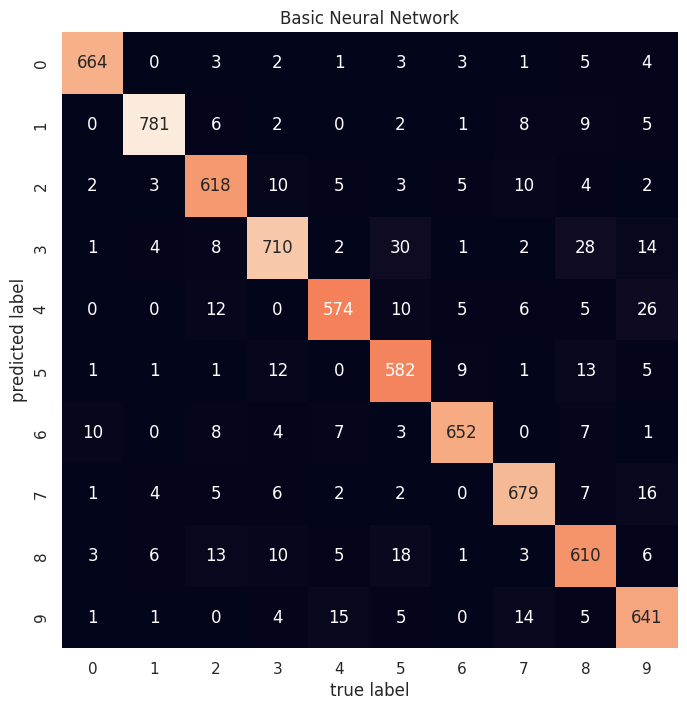

In [ ]:
#@title Basic Neural Network Algorithm

class DeepNeuralNetworkLearningAlgorithm(BaseLearningAlgorithm):
    def __init__(self, sizes, epochs=10, l_rate=0.001, batch_size=64, activation_function='relu', early_stopping=False, patience=5, min_delta=0.01):
        self.sizes = sizes
        self.epochs = epochs
        self.l_rate = l_rate
        self.batch_size = batch_size
        self.early_stopping = early_stopping
        self.patience = patience
        self.min_delta = min_delta

        # choose the supported activation function
        if activation_function == 'sigmoid':
          self.activation = self.sigmoid
        elif activation_function == 'relu':
          self.activation = self.relu
        else:
          raise ValueError(f"Unsupported activation function: {activation_function}")

        # Save all parameters in the neural network in this dictionary
        self.params = self.initialization()

    def sigmoid(self, x, derivative=False):
        if derivative:
            return (np.exp(-x))/((np.exp(-x)+1)**2)
        return 1/(1 + np.exp(-x))

    def relu(self, x, derivative=False):
        if derivative:
            return (x > 0).astype(int)
        return np.maximum(0, x)

    def softmax(self, x, derivative=False):
        exps = np.exp(x - x.max())
        if derivative:
            return exps / np.sum(exps, axis=0) * (1 - exps / np.sum(exps, axis=0))
        return exps / np.sum(exps, axis=0)

    def initialization(self):
        # number of nodes in each layer
        input_layer = self.sizes[0]
        hidden_1 = self.sizes[1]
        hidden_2 = self.sizes[2]
        output_layer = self.sizes[3]

        # He initialization fore ReLU
        params = {
            'W1':np.random.randn(hidden_1, input_layer) * np.sqrt(1. / hidden_1),
            'W2':np.random.randn(hidden_2, hidden_1) * np.sqrt(1. / hidden_2),
            'W3':np.random.randn(output_layer, hidden_2) * np.sqrt(1. / output_layer)
        }

        # Xavier initialization for sigmoid (does not work well for some reason)
        # params = {
        #     'W1':np.random.randn(hidden_1, input_layer) * np.sqrt(1. / input_layer),
        #     'W2':np.random.randn(hidden_2, hidden_1) * np.sqrt(1. / hidden_1),
        #     'W3':np.random.randn(output_layer, hidden_2) * np.sqrt(1. / hidden_2)
        # }

        return params

    def compute_average_gradient(self, batch_gradients):
        average_gradient = {}
        for key in batch_gradients[0].keys():
            average_gradient[key] = np.mean([grad[key] for grad in batch_gradients], axis=0)
        return average_gradient

    def forward_pass(self, x_train: np.array) -> np.array:
        params = self.params

        # input layer activations becomes sample
        params['A0'] = x_train

        # input layer to hidden layer 1
        params['Z1'] = np.dot(params["W1"], params['A0'])
        params['A1'] = self.activation(params['Z1'])

        # hidden layer 1 to hidden layer 2
        params['Z2'] = np.dot(params["W2"], params['A1'])
        params['A2'] = self.activation(params['Z2'])

        # hidden layer 2 to output layer
        params['Z3'] = np.dot(params["W3"], params['A2'])
        params['A3'] = self.softmax(params['Z3'])

        return params['A3']

    def backward_pass(self, y_train: np.array, output: np.array) -> Dict[str, np.array]:
        """Perfoms backpropagation."""
        params = self.params
        change_w = {}

        # Calculate W3 update
        error = 2 * (output - y_train) / output.shape[0] * self.softmax(params['Z3'], derivative=True)
        change_w['W3'] = np.outer(error, params['A2'])

        # Calculate W2 update
        error = np.dot(params['W3'].T, error) * self.activation(params['Z2'], derivative=True)
        change_w['W2'] = np.outer(error, params['A1'])

        # Calculate W1 update
        error = np.dot(params['W2'].T, error) * self.activation(params['Z1'], derivative=True)
        change_w['W1'] = np.outer(error, params['A0'])

        return change_w

    def update_network_parameters(self, changes_to_w: Dict[str, np.array]):
        """Updates network parameters according to update rule from
            Stochastic Gradient Descent.

            θ = θ - η * ∇J(x, y),
                theta θ:            a network parameter (e.g. a weight w)
                eta η:              the learning rate
                gradient ∇J(x, y):  the gradient of the objective function,
                                    i.e. the change for a specific theta θ
        """

        for key, value in changes_to_w.items():
            self.params[key] -= self.l_rate * value

    def compute_accuracy(self, x_val, y_val):
        """
            This function does a forward pass of x, then checks if the indices
            of the maximum value in the output equals the indices in the label
            y. Then it sums over each prediction and calculates the accuracy.
        """
        predictions = []
        y_val = to_categorical(y_val)
        for x, y in zip(x_val, y_val):

            output = self.forward_pass(x)
            pred = np.argmax(output)
            predictions.append(pred == np.argmax(y))

        return np.mean(predictions)

    def predict(self, X_test: np.array) -> np.array:
      """Predicts on a test set."""
      return np.array([str(np.argmax(self.forward_pass(x))) for x in X_test]).astype('float32')

    def fit(self, x_train, y_train, x_val, y_val):
        best_val_accuracy = 0
        best_params = None
        epochs_without_improvement = 0

        y_train = to_categorical(y_train)

        # mini-batch
        start_time = time.time()
        for iteration in range(self.epochs):
            mini_batches = generate_mini_batches(x_train, y_train, self.batch_size)
            for (x_batch, y_batch) in mini_batches:
                batch_gradients = []
                for x, y in zip(x_batch, y_batch):
                    output = self.forward_pass(x)
                    changes_to_w = self.backward_pass(y, output)
                    batch_gradients.append(changes_to_w)
                average_gradient = self.compute_average_gradient(batch_gradients)
                self.update_network_parameters(average_gradient)

            accuracy = self.compute_accuracy(x_val, y_val)

            # early stopping is applied here
            if self.early_stopping:
              if accuracy - best_val_accuracy > self.min_delta:
                best_val_accuracy = accuracy
                best_params = self.params
                epochs_without_improvement = 0
              else:
                epochs_without_improvement += 1

              # loading best params
              if epochs_without_improvement > self.patience:
                print("Early stopping applied")
                self.params = best_params
                break

            print('Epoch: {0}, Time Spent: {1:.2f}s, Validation Accuracy: {2:.2f}%'.format(
                iteration+1, time.time() - start_time, accuracy * 100
            ))
    @property
    def name(self) -> str:
      return 'Basic Neural Network'

learning_algo = DeepNeuralNetworkLearningAlgorithm(sizes=[784, 128, 64, 10], epochs=30, l_rate=0.1,
                                                   activation_function='relu',
                                                   early_stopping=True, patience=5, min_delta=0.01)
%time train_eval(learning_algo, x_train, y_train, x_val, y_val, x_test, y_test)

##Question 5.
When executing multiple times (using ReLU or sigmoid activations) for a fixed number of iterations, how much does the validation accuracy vary at the end of the training? What is causing the variation in performance?

- 10 epochs with **sigmoid** activation function:
  - **1. Run:** initial accuracy --> 18.97%, final accuracy -->  57.29%

  - **2. Run** initial accuracy --> 22.59%, final accuracy --> 57.30%

  - **3. Run** initial accuracy --> 23.56%, final accuracy --> 61.32%

- 10 epochs with **ReLU** activation function:

  - **1. Run:** initial accuracy --> 72.27%, final accuracy --> 92.10%

  - **2. Run** initial accuracy --> 74.68%, final accuracy --> 91.67%

  - **3. Run** initial accuracy --> 73.11%, final accuracy --> 92.17%

- Considering using sigmoid function I trained the models couple of times as seen from the provided logs above we can see that both initial and final accuracies differs from each other but there is not significant difference. The reason comes from the initializaiton of the weghts as we sample random values from normal distribution. And this causes model to sometimes be lucky and get better final accuracy as a final step. For example, in the 3rd run, the model got more lucky in the initialization (23.56%) thus ended up with higher accuracy (61.32%).

- Also, one other reason could be regarding to the optimizaiton as we know that neural networks with non-linear activation functions have non-convex with lots of potential local minimas. Having different initializations we may have ended up in different points.


## Question 6.
Does the choice of activation function (ReLU vs. sigmoid) make any difference in validation accuracy?
- In the provided logs, models with ReLU activations outperform those with Sigmoid, achieving an average final accuracy of approximately 91.98% compared to Sigmoid's 58.64% in 10 epochs. I suspect it is because to ReLU's non-saturating nature, which mitigates the vanishing gradient problem, allowing for faster and more effective training. I have also researched that it may be because of the initializaiton. For instance in the code we use "He" initialization which is preferred for the **ReLU** activation function and there are other methods like "Xavier" initialization. I tested boht but did not get much gain in for the **sigmoid** activation in terms of the performance which may be due to the simplicity of the architecture.

##4.2 Feedforward Neural Network with Keras and Tensorflow (Task 6)
Next, set up and train a feedforward neural network in [Keras](https://keras.io/) and [Tensorflow](https://www.tensorflow.org/).



1.   Paramaterize your model with the number of hidden layers, epochs, learning rate, and activation function.
  - **DONE**
2.   Add **early stopping** and add a patience parameter. You can apply the [keras callback function](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping) to implement early stopping.
  - **DONE**
3.   Apply sparse categorical entropy loss function.
  - **DONE**
4.   Apply Adaptive Moments (Adam) optimizer
  - **DONE**





Epoch 1/100
1772/1772 [==============================] - 14s 4ms/step - loss: 0.2601 - accuracy: 0.9219 - val_loss: 0.0994 - val_accuracy: 0.9695
Epoch 2/100
1772/1772 [==============================] - 7s 4ms/step - loss: 0.1112 - accuracy: 0.9678 - val_loss: 0.0979 - val_accuracy: 0.9695
Epoch 3/100
1772/1772 [==============================] - 7s 4ms/step - loss: 0.0779 - accuracy: 0.9772 - val_loss: 0.0725 - val_accuracy: 0.9757
Epoch 4/100
1772/1772 [==============================] - 9s 5ms/step - loss: 0.0603 - accuracy: 0.9823 - val_loss: 0.0786 - val_accuracy: 0.9797
Epoch 5/100
1772/1772 [==============================] - 7s 4ms/step - loss: 0.0489 - accuracy: 0.9854 - val_loss: 0.0858 - val_accuracy: 0.9787
Epoch 6/100
1772/1772 [==============================] - 7s 4ms/step - loss: 0.0431 - accuracy: 0.9874 - val_loss: 0.0713 - val_accuracy: 0.9802
Epoch 7/100
1772/1772 [==============================] - 8s 4ms/step - loss: 0.0391 - accuracy: 0.9887 - val_loss: 0.0640 - val_a

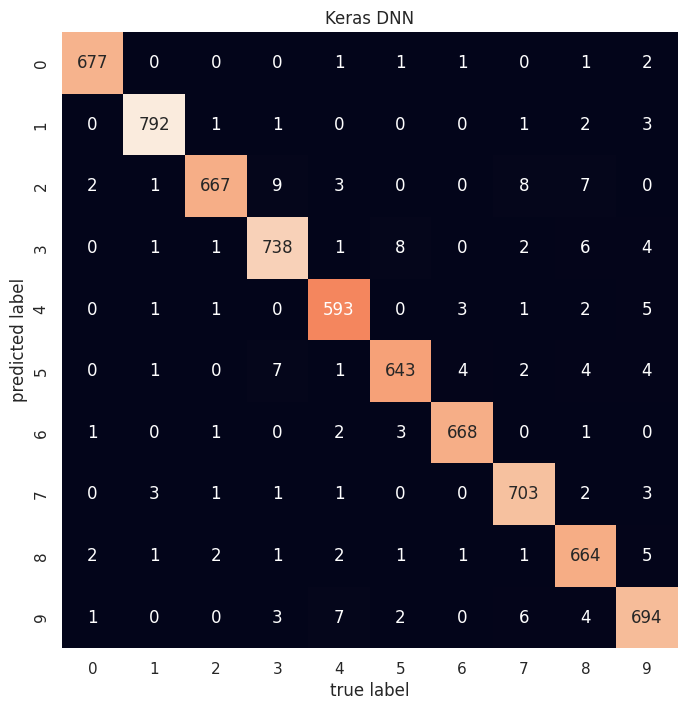

In [ ]:
class KerasDnnLearningAlgorithm(BaseLearningAlgorithm):
  """Keras DNN Learning Algorithm"""
  def __init__(self, input_dim, output_dim, hidden_layers, activation, batch_size=32, epochs=10, learning_rate=0.001, patience=5, dropout=0.2):
    self.hidden_layers = hidden_layers
    self.activation = activation
    self.epochs = epochs
    self.batch_size = batch_size
    self.learning_rate = learning_rate
    self.patiance = patience
    self.dropout = dropout
    self._model = self._get_model(input_dim, output_dim, hidden_layers, activation)

  def _get_model(self, input_dim, output_dim, hidden_layers, activation):
    model = tf.keras.Sequential()

    # input layer
    model.add(
      tf.keras.layers.Dense(
        input_dim, input_dim=input_dim, activation=activation))

    # hidden and droput layers
    for layer_width in hidden_layers:
      model.add(
        tf.keras.layers.Dense(
          layer_width, activation=activation))
      model.add(tf.keras.layers.Dropout(self.dropout))

    # output layer
    model.add(tf.keras.layers.Dense(output_dim, activation='softmax'))

    model.compile(
      loss='sparse_categorical_crossentropy',
      optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate),
      metrics=['accuracy'])
    return model

  def predict(self, X_test: np.array) -> np.array:
    """Predicts on a test set."""
    # return class labels by taking the max element index using the last dimension
    return np.argmax(self._model.predict(X_test), axis=-1)

  def fit(self, x_train, y_train, x_val, y_val):
    y_train = y_train.astype('int32')
    y_val = y_val.astype('int32')
    early_stopping = tf.keras.callbacks.EarlyStopping(
      monitor='val_loss', patience=self.patiance)
    self._model.fit(
       x_train, y_train,
       epochs=self.epochs,
       validation_data=(x_val, y_val),
       callbacks=[early_stopping],
       batch_size=self.batch_size
    )

  @property
  def name(self) -> str:
     return 'Keras DNN'


learning_algo = KerasDnnLearningAlgorithm(input_dim=784, output_dim=10, hidden_layers=[128, 64],
                                          epochs=100, learning_rate=0.001, activation = 'relu',
                                          dropout=0.2)
%time train_eval(learning_algo, x_train, y_train, x_val, y_val, x_test, y_test)

##Question 6
Summarize the results of all your classifiers. Which classifiers performed better or worse than the logistic regression benchmark? Which method executed fastest in terms of time? Which was easiest to set up and parameterize? Which classes tended to get most often confused across all classifiers?

- Even though we get decent results with all the methods, we have to use Neural Network approach for this specific case where we train a model to classify an image for couple of reasons.
- As shown from the table below, all the models but Neural Network with a sigmoid funciton surpassed base Logistic Regression model. Overall, Keras implementation Neural Network outperformed all the other models with 98% accuracy.
- If we consider using T4 GPU in Colab then the fastest training time goes to the Keras Neural Network with 1.5m. But if we only use CPU then the fastest one was the Radial Basis SVM with PCA because of the reduced features dimensionality to 71 components. And this shows how useful is PCA.
- In my opinion, implementing `DeepNeuralNetworkLearningAlgorithm` from scratch was most challenging one. Other than that other models were straightforward to set up and parameterize such as Logistic Regression, SVM, Decision Tree as they are all abstracted by `scikit-learn` package.

- Generally speaking, pairs `(4, 9), (2, 7), (2, 3), (3, 5)` tend to be confused more accross the models.
<br><br>

<center>

|| Model | Accuracy | Time (min) |  Note ||
| --- | --- | --- | --- | --- | --- |
| 0 | Logistic Regression | 92% | 5m | |
| 1 | Radial Basis SVM | 93% | 10m | |
| 2 | Radial Basis SVM with PCA | 93% | 2m | 71 components |
| 3 | Random Forest | 96% | 4m | |
| 4 | Deep Neural Network with Numpy (ReLU) | 94% | 12m | 21 epochs with Early Stopping |
| 5 | Deep Neural Network with Numpy (sigmoid) | 73% | 25m | 35 epochs with Early Stopping |
| 6 | Deep Neural Network with TF and Keras (GPU) | 98% | 1m | 9 epochs, early stopping, 32 batch size|
| 7 | Deep Neural Network with TF and Keras (CPU) | 98% | 4m | 10 epochs, early stopping, 32 batch size |

</center>

<br>

#Optional Extra Credit (max course credit: 3%)


*   Implement early stopping in 4.1 (**1% extra credit**).
  - **DONE**
*   Add in one or more Keras dropout layers in 4.2 (**1% extra credit**).
  - **DONE**
*   Implement mini-batch gradient descent in 4.1, replacing stochastic gradient descent. Instead of making an update to a parameter for each sample, make an update based on the averaged value of each sample in a mini-batch. The size of the mini-batch is usually below 64. (**3% extra credit**)
  - **DONE**
*  Initialize biases and add them to Z in 4.1 before the activation function in the forward pass, and update the biases in the backward pass.  (**2% extra credit**)


